In [1]:
# This version of the SVD fits using states expressed as excitations relative to a nuclear ground state
# RMS error for this fit looks to be a match with e35 produced by BAB
import random
import math
import scipy.linalg

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.animation as animation

plt.rc('axes', labelsize=20)
plt.rc('xtick', labelsize=15)
plt.rc('ytick', labelsize=15)
plt.rcParams["font.family"] = "Times New Roman"

from matplotlib.ticker import (MultipleLocator, FormatStrFormatter, AutoMinorLocator)
from numpy.linalg import inv
from scipy import stats
from IPython.display import Image

# Read output-energy file as fixed-width file (fwf) into dataframe object, columns aren't labeled with a header
energyDF = pd.read_csv('xfit.dat', header=None, delim_whitespace=True).to_numpy()
dataIn = pd.read_fwf('exp.dai', header=None, delim_whitespace=True).to_numpy()
nuclei = dataIn[:,6]

# extract the SPEs and TBME's for the background (n50em) interaction
backgroundHam = energyDF[0,5:75]      # First 5 terms are not Hamiltonian parameters and can be dropped

# do the same for the fitted interaction from BAB
fittedHam = energyDF[1,5:75]

# extract experimental energies and experimental errors from dataframe
exp = energyDF[2:,1]
expAbs = energyDF[2:,2]
error = energyDF[2:,3]
#print(exp)

# extract matrix of beta coefficients for calculating absolute energies of each state
betasAbs = energyDF[2:,5:]

# extract a matrix of the beta coefficients in each energy contribution for the Hamiltonian in terms of excited states
betas = np.empty([len(exp),len(backgroundHam)])
for i in range(len(exp)):
    for j in range(len(backgroundHam)):
        if exp[i] <= 0:
            betas[i,j] = energyDF[i+2,j+5]
            gsContributions = betas[i,:]
        else:
            betas[i,j] = energyDF[i+2,j+5] - gsContributions[j]

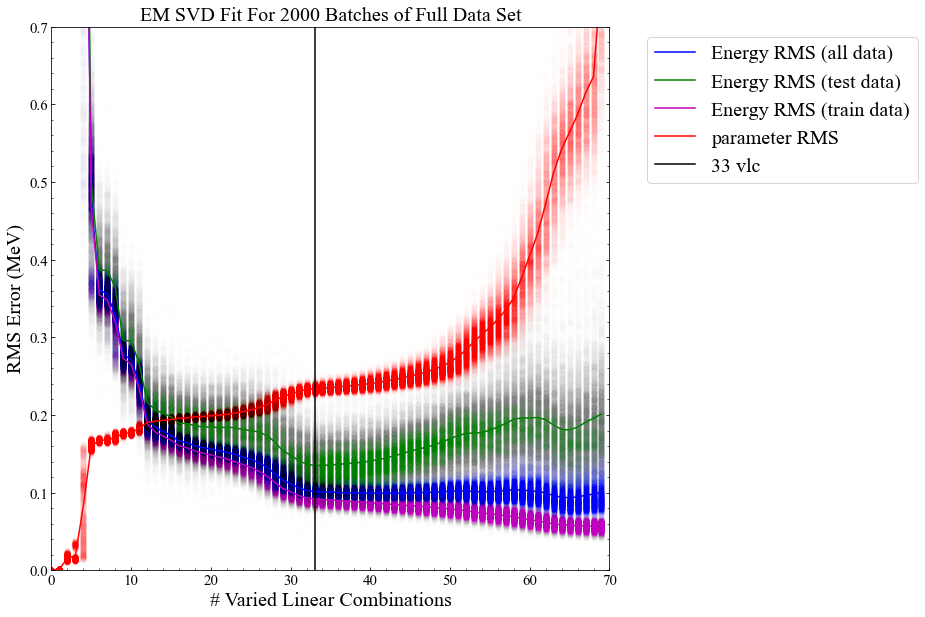

In [6]:
# This segment iterates (numBatches times) over randomized batches of the available data (including all ground states)
# All excited states from 79Cu to 99In are available for building training batches
# The full dataset is used for testing

numBatches = 2000
eRMSRangeAll = np.empty([numBatches,len(backgroundHam)+1])
eRMSRangeTest = np.empty([numBatches,len(backgroundHam)+1])
eRMSRangeTrain = np.empty([numBatches,len(backgroundHam)+1])
pRMSRange = np.empty([numBatches, len(backgroundHam)+1])

# These arrays hold information pertaining to fits that have a test data RMS > 250 keV
highRMSparams = []
highRMSbatch = []
highRMSresiduals = []
dataPercent = 0.8               # percent of the dataset to include in the testing sets

for b in range(numBatches):
    # Select a random batch of data to fit the parameters to (making sure that ground states are always included in the batch)
    batchChoice = np.zeros(len(exp))
    random.seed()
    for i in range(len(exp)):
        if exp[i] <= 0.0:
            batchChoice[i] = 1
        else:
            k = random.random()
            if k >= 1-dataPercent:
                batchChoice[i] = 1

    batchExp = np.empty(int(np.sum(batchChoice)))
    batchError = np.empty(len(batchExp))
    batchBetas = np.empty([len(batchExp), len(backgroundHam)])
    batchIndex = 0
    for i in range(len(exp)):
        if batchChoice[i] == 1:
            batchExp[batchIndex] = exp[i]
            batchError[batchIndex] = error[i]
            batchBetas[batchIndex] = betas[i]
            batchIndex += 1
                    
    # Finally we construct our design matrix (G), initial parameter vector (pInit), and data vector (e) for fitting
    e = np.empty(len(backgroundHam))
    G = np.empty((len(backgroundHam),len(backgroundHam)))
    for i in range(len(backgroundHam)):           # Contructing data vector (e)
        eTot = 0
        for k in range(len(batchExp)):
            eTot += (batchExp[k]*batchBetas[k,i])/(batchError[k]**2)
        e[i] = eTot
    for i in range(len(backgroundHam)):           # Constructing design matrix (G)
        for j in range(len(backgroundHam)):
            gTot = 0
            for k in range(len(batchExp)):
                gTot += (batchBetas[k,i]*batchBetas[k,j])/(batchError[k]**2)
            G[i,j] = gTot

    # Here we perform an SVD of our design matrix and invert the singular values (in S)
    # to create linear combinations of our parameters in p for our successive fits, iterating over the singular values
    U, Svec, Ut = np.linalg.svd(G)
    # Now we apply our minimization (e = Gp) by using our SVD matrices U,S, and Ut to rotate
    # e and p into new vectors c and y, respectively
    c = np.dot(Ut,e)
    y = np.dot(Ut,backgroundHam)

    # This is where we iteratively vary the linear combinations of parameters by selecting the increasing values in Sinv
    # at the end we will apply fitted weights p to our initial parameters to calculate their RMS and energy RMS
    pRMS = np.empty(len(Svec)+1)                  # The +1 is to include the unfitted case where we vary 0 linear combinations
    fitEnergies = np.empty(len(exp))              # Array for storing fitted energies resulting from the chosen #VLC fit
    numVLC = 33                                   # Number of VLC to choose for the output Hamiltonian
    for i in range(len(backgroundHam)+1):
        yfit = np.empty(len(backgroundHam))
        fitParameters = np.empty(len(backgroundHam))               # Array for storing fitted parameters in this iteration
        eResidualAll = np.empty(0)                             # Array for storing residuals for RMS calculation
        eResidualTest = np.empty(0)
        eResidualTrain = np.empty(0)
        for j in range(len(backgroundHam)):
            if j < i:                             # Modify our linear combinations in y = U^Tp by our data in c = U^Te
                yfit[j] = c[j]/Svec[j]
            elif j >= i:                           # Keep the original linear combinations y = U^Tp from starting Hamiltonian
                yfit[j] = y[j]
        fitParameters = np.dot(U,yfit)                      # Rotate back to our fitted p vector through p = Uy
        for j in range(len(exp)):
            eFitTot = 0
            for k in range(len(backgroundHam)):
                eFitTot += fitParameters[k]*betas[j,k]                # Modify our initial energy contributions to state j by new weights
            if error[j] <= 1.0:
                eResidualAll = np.append(eResidualAll, exp[j]-eFitTot)
                if batchChoice[j] == 0:
                    eResidualTest = np.append(eResidualTest, exp[j]-eFitTot)
                elif batchChoice[j] ==1:
                    eResidualTrain = np.append(eResidualTrain, exp[j]-eFitTot)
        pResidual = backgroundHam - fitParameters
        eRMSRangeAll[b,i] = scipy.linalg.norm(eResidualAll)/math.sqrt(len(eResidualAll))
        eRMSRangeTest[b,i] = scipy.linalg.norm(eResidualTest)/math.sqrt(len(eResidualTest))
        eRMSRangeTrain[b,i] = scipy.linalg.norm(eResidualTrain)/math.sqrt(len(eResidualTrain))
        pRMSRange[b,i] = scipy.linalg.norm(pResidual)/math.sqrt(len(pResidual))
        if i == numVLC:
            outputHam = fitParameters

# Convert all lists into np arrays
highRMSbatch = np.array(highRMSbatch)
highRMSparams = np.array(highRMSparams)
highRMSresiduals = np.array(highRMSresiduals)

# For a given number of singular values, calculate the averave RMSE across batches
eRMSaverageAll = np.empty(len(pRMS))
eRMSaverageTest = np.empty(len(pRMS))
eRMSaverageTrain = np.empty(len(pRMS))
pRMSaverage = np.empty(len(pRMS))
for i in range(len(pRMS)):
    eRMSaverageAll[i] = np.sum(eRMSRangeAll[:,i])/numBatches
    eRMSaverageTest[i] = np.sum(eRMSRangeTest[:,i])/numBatches
    eRMSaverageTrain[i] = np.sum(eRMSRangeTrain[:,i])/numBatches
    pRMSaverage[i] = np.sum(pRMSRange[:,i])/numBatches

#print('35 vlc eRMS (average) =', eRMSaverageAll[34], ' pRMS (average) = ', pRMSaverage[34])
#print('full SVD eRMS =', eRMSaverageAll[69], ' pRMS =', pRMSaverage[69])
#print('BAB parameter RMS = ', scipy.linalg.norm(backgroundHam-fittedHam)/math.sqrt(len(backgroundHam)))

x = [i for i in range(len(pRMS))] 
f = plt.figure()
f.set_figwidth(10)
f.set_figheight(10)
alphaValue = 10/numBatches
for i in range(numBatches):
    #plt.scatter(x, eRMSRangeAll[i], color='b', alpha=alphaValue)
    plt.scatter(x, eRMSRangeTest[i], color='g', alpha=alphaValue)
    plt.scatter(x, eRMSRangeTrain[i], color='m', alpha=alphaValue)
    plt.scatter(x, pRMSRange[i], color='r', alpha=alphaValue)
#plt.plot(x, eRMSaverageAll, label='Energy RMS (all data)', color='b')
plt.plot(x, eRMSaverageTest, label='Energy RMS (test data)', color='g')
plt.plot(x, eRMSaverageTrain, label='Energy RMS (train data)', color='m')
plt.plot(x, pRMSaverage, label='parameter RMS', color='r')
plt.axvline(x = numVLC, color = 'k', label = '%i vlc' %numVLC)
plt.xlabel('# Varied Linear Combinations')
plt.ylabel('RMS Error (MeV)')
plt.title('EM SVD Fit For %i Batches of Full Data Set' %numBatches, fontsize=20)
plt.axis([0,70,0.0,0.7])
plt.minorticks_on()
plt.tick_params(which="both", direction="in", right=True)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left',fontsize=20).set_alpha(1)
plt.show()

The red curve is the RMSE between our starting hamiltonian parameter values and our fitted values at each number of varied linear combinations of parameters (VLC's) - in other words for each number of singular values of the inverted design matrix chosen to weight the starting linear combinations of parameters.

The magenta curve is the RMSE due only to residuals between the data used to fit (train) the Hamiltonian parameters before and after the fit.
The green curve is the RMSE due only to the residuals between the data outside of the training sets (test data) before and after the fit. 
The blue curve is the RMSE due to the residual between all data (test and training) before and after the fit.

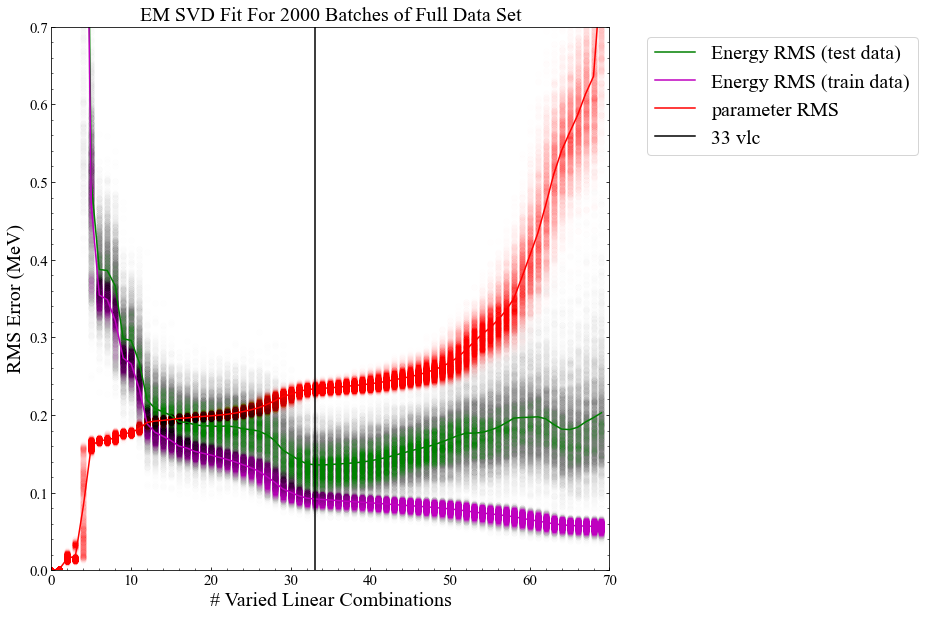

In [5]:
x = [i for i in range(len(pRMS))] 
f = plt.figure()
f.set_figwidth(10)
f.set_figheight(10)
alphaValue = 10/numBatches
for i in range(numBatches):
    #plt.scatter(x, eRMSRangeAll[i], color='b', alpha=alphaValue)
    plt.scatter(x, eRMSRangeTest[i], color='g', alpha=alphaValue)
    plt.scatter(x, eRMSRangeTrain[i], color='m', alpha=alphaValue)
    plt.scatter(x, pRMSRange[i], color='r', alpha=alphaValue)
#plt.plot(x, eRMSaverageAll, label='Energy RMS (all data)', color='b')
plt.plot(x, eRMSaverageTest, label='Energy RMS (test data)', color='g')
plt.plot(x, eRMSaverageTrain, label='Energy RMS (train data)', color='m')
plt.plot(x, pRMSaverage, label='parameter RMS', color='r')
plt.axvline(x = numVLC, color = 'k', label = '%i vlc' %numVLC)
plt.xlabel('# Varied Linear Combinations')
plt.ylabel('RMS Error (MeV)')
plt.title('EM SVD Fit For %i Batches of Full Data Set' %numBatches, fontsize=20)
plt.axis([0,70,0.0,0.7])
plt.minorticks_on()
plt.tick_params(which="both", direction="in", right=True)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left',fontsize=20).set_alpha(1)
plt.show()

In [10]:
print(nuclei.shape, highRMSbatch.shape, highRMSparams.shape, highRMSresiduals.shape)
allOutputs = []
allOutputs.append(nuclei)
allOutputs.append(exp)
formatString = '%2s %10.4f '
for i in range(highRMSbatch[:,0].size):
    bigResiduals = []
    for j in range(exp.size):
        if (abs(highRMSresiduals[i,j]) >= 0.25) and (error[j] <= 1.0):
            bigResiduals.append('X')
        else:
            bigResiduals.append(' ')
    allOutputs.append(highRMSbatch[i])
    allOutputs.append(highRMSresiduals[i])
    allOutputs.append(bigResiduals)
    formatString = formatString + '%10i %10.4f %-s'
allOutputs = np.array(allOutputs)
print(formatString)

(202,) (0,) (0,) (0,)


IndexError: too many indices for array: array is 1-dimensional, but 2 were indexed

In [4]:
outputs1 = np.array([nuclei, allOutputs])
with open("Test.dat","w") as f:
    f.write("Outputs for batches with RMSE >= 250 keV \n")
    f.write("All residuals with a '1' next to them were data included in the training. \n")
    f.write("          exp      Train        Res \n")
    #np.savetxt(f, outputs1.T, delimiter=' ', fmt='%s')
    np.savetxt(f, allOutputs.T, delimiter=' ', fmt=formatString)

/var/folders/jk/17h981893fbgnql3g8mcf5fr0000gn/T/ipykernel_46162/640249673.py:1: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  outputs1 = np.array([nuclei, allOutputs])


AttributeError: 'list' object has no attribute 'T'

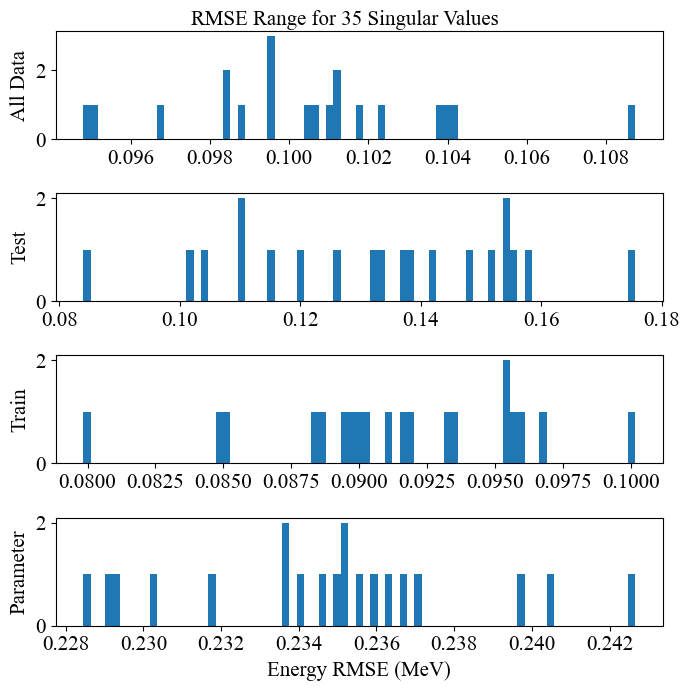

In [11]:
nSVD = 35
fs = 15
nBins = 75
fig, axs = plt.subplots(nrows=4, ncols=1, figsize=(7,7))

axs[0].hist(eRMSRangeAll[:,nSVD], bins=nBins)
axs[1].hist(eRMSRangeTest[:,nSVD], bins=nBins)
axs[2].hist(eRMSRangeTrain[:,nSVD], bins=nBins)
axs[3].hist(pRMSRange[:,nSVD], bins=nBins)
axs[3].set_xlabel('Energy RMSE (MeV)', fontsize=fs)
axs[0].set_ylabel('All Data', fontsize=fs)
axs[1].set_ylabel('Test', fontsize=fs)
axs[2].set_ylabel('Train', fontsize=fs)
axs[3].set_ylabel('Parameter', fontsize=fs)
#axs[0].grid(True)

fig.tight_layout()
fig.subplots_adjust(hspace=0.5, top=0.95)
plt.suptitle("RMSE Range for %i Singular Values" %nSVD, fontsize=fs)
plt.show()
#plt.hist(eRMSRangeTest[:,25], bins=50)
#plt.show()

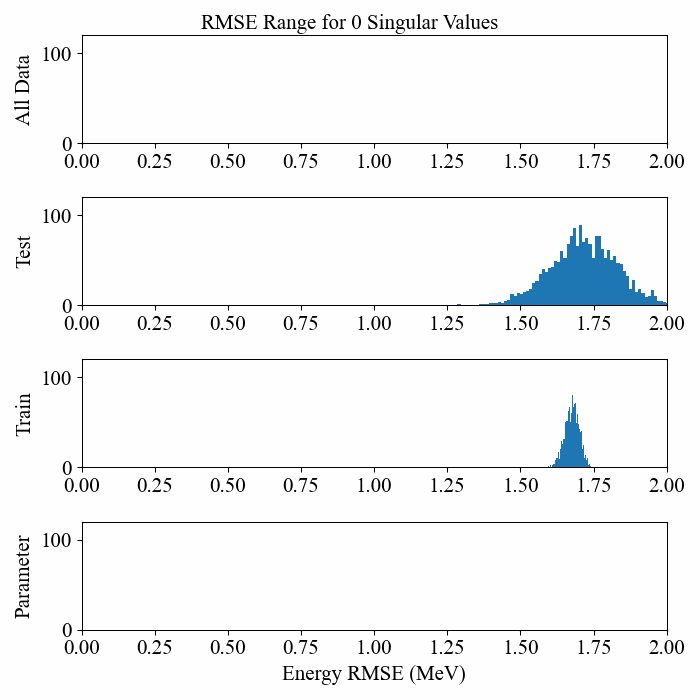

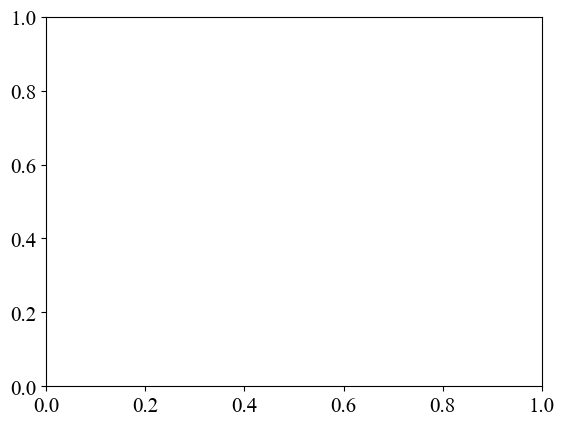

In [9]:
frame, axes = plt.subplots()
fs = 15
nBins = 75
fig, axs = plt.subplots(nrows=4, ncols=1, figsize=(7,7))
def animate(i):
    axs[0].clear()
    axs[1].clear()
    axs[2].clear()
    axs[3].clear()
    axs[0].hist(eRMSRangeAll[:,i], bins=nBins)
    axs[1].hist(eRMSRangeTest[:,i], bins=nBins)
    axs[2].hist(eRMSRangeTrain[:,i], bins=nBins)
    axs[3].hist(pRMSRange[:,i], bins=nBins)
    axs[3].set_xlabel('Energy RMSE (MeV)', fontsize=fs)
    axs[0].set_ylabel('All Data', fontsize=fs)
    axs[1].set_ylabel('Test', fontsize=fs)
    axs[2].set_ylabel('Train', fontsize=fs)
    axs[3].set_ylabel('Parameter', fontsize=fs)

    axs[0].set_xlim(left=0, right=2.0)
    axs[1].set_xlim(left=0, right=2.0)
    axs[2].set_xlim(left=0, right=2.0)
    axs[3].set_xlim(left=0, right=2.0)
    axs[0].set_ylim(bottom=0, top=120)
    axs[1].set_ylim(bottom=0, top=120)
    axs[2].set_ylim(bottom=0, top=120)
    axs[3].set_ylim(bottom=0, top=120)
    fig.tight_layout()
    fig.subplots_adjust(hspace=0.5, top=0.95)
    plt.suptitle("RMSE Range for %i Singular Values" %i, fontsize=fs)
  
ani = animation.FuncAnimation(fig, animate, repeat=True, frames=len(x), interval=250)
f = r'batchAnimation80p.gif'
writergif = animation.PillowWriter(fps=10)
ani.save(f,writer=writergif)
plt.close()
Image(open('batchAnimation80p.gif','rb').read())